Take Home Assignment 3

3.0 Install any dependencies if needed 


In [1]:
!pip install supervision
!pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import time
import supervision as sv

3.1.1 Draw the segmentation mask of the largest car: Use ultralytics library only


0: 416x640 14 cars, 2418.7ms
Speed: 27.4ms preprocess, 2418.7ms inference, 82.7ms postprocess per image at shape (1, 3, 416, 640)


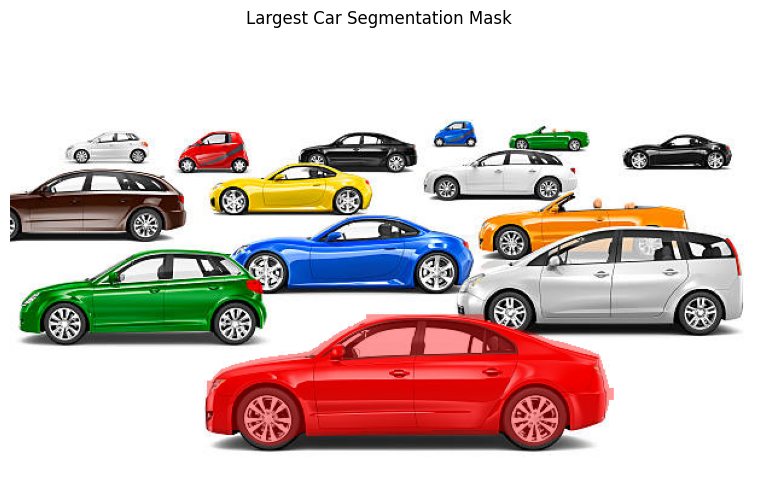

True

In [4]:
from ultralytics import YOLO
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load YOLOv8 segmentation model
model = YOLO("yolov8m-seg.pt")

# Load and preprocess the image
img = cv2.imread("cars1.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
original_height, original_width = img.shape[:2]  # Get original dimensions

# Run the segmentation model
results = model(img_rgb)

# Extract detected objects
masks = results[0].masks  # Get segmentation masks
boxes = results[0].boxes.xyxy  # Get bounding boxes

# Convert bounding boxes to NumPy (to avoid PyTorch tensor indexing issues)
boxes = boxes.cpu().numpy() if isinstance(boxes, torch.Tensor) else boxes

if masks is None or len(boxes) == 0:
    print("No objects detected in the image.")
else:
    # Find the largest car by bounding box area
    largest_index = max(range(len(boxes)), key=lambda i: (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]))
    
    # Get the corresponding mask
    largest_mask = masks.data[largest_index].cpu().numpy()

    # Resize the mask to match the original image size
    mask_resized = cv2.resize(largest_mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
    
    # Convert to binary mask with proper normalization
    binary_mask = (mask_resized / np.max(mask_resized) > 0.5).astype(np.uint8)

    # Ensure mask shape matches the image shape
    if binary_mask.shape[:2] == img_rgb.shape[:2]:
        # Apply mask overlay with red color
        img_rgb[binary_mask == 1] = img_rgb[binary_mask == 1] * 0.6 + np.array([255, 0, 0]) * 0.4
    else:
        print("Error: Resized mask shape does not match image shape!")

# Display the result
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Largest Car Segmentation Mask")
plt.show()

# Save output image
cv2.imwrite("output.jpg", cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))


In [ ]:
img = cv2.imread("demo5_images/cars1.jpg")

In [ ]:
# Run a segmentation model on the image 

# Iterate through the boxes in the results object 
    # For each box , obtain the coordinates of the box, evaluate area
    # Find out the index of the box with the largest area

# Draw the mask of the box with the largest area. 

3.1.2 Draw the segmentation mask of the largest car : Use ultralytics + supervision libraries

In [ ]:
# Run a segmentation model on the image using ultralytics libraries & a model of your choice

# Transfer ultralytics results to supervision

# Iterate through the masks & find the largest

# Display the largest mask


0: 416x640 14 cars, 2404.5ms
Speed: 7.0ms preprocess, 2404.5ms inference, 35.8ms postprocess per image at shape (1, 3, 416, 640)


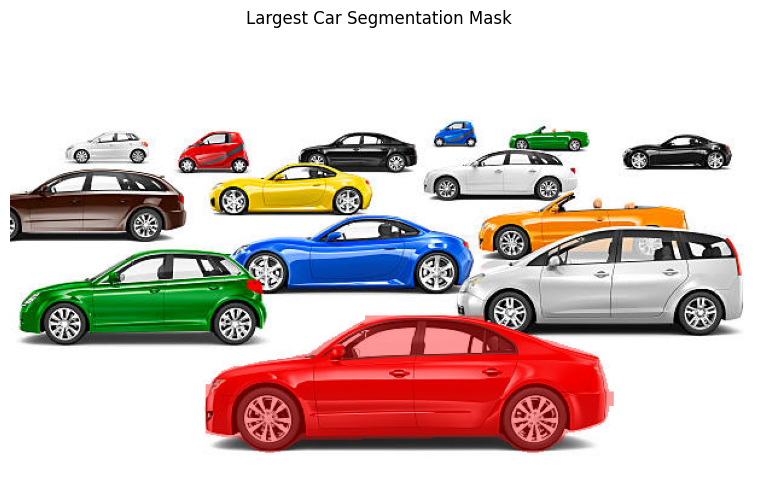

In [5]:
from ultralytics import YOLO
import supervision as sv
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load YOLOv8 segmentation model
model = YOLO("yolov8m-seg.pt")

# Load the image
img = cv2.imread("cars1.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
original_height, original_width = img.shape[:2]  # Get original dimensions

# Run the segmentation model
results = model(img_rgb)

# Transfer Ultralytics results to Supervision format
detections = sv.Detections.from_ultralytics(results[0])

# Extract masks and bounding boxes
masks = detections.mask
boxes = detections.xyxy

if masks is not None and len(boxes) > 0:
    # Find the index of the largest car by bounding box area
    largest_index = max(range(len(boxes)), key=lambda i: (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]))

    # Get the corresponding mask and convert it to binary
    largest_mask = masks[largest_index]
    binary_mask = (largest_mask > 0.5).astype(np.uint8)

    # Ensure mask size matches image size
    if binary_mask.shape[:2] != (original_height, original_width):
        binary_mask = cv2.resize(binary_mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

    # Apply mask overlay with red color
    img_rgb[binary_mask == 1] = img_rgb[binary_mask == 1] * 0.6 + np.array([255, 0, 0]) * 0.4

# Display the result
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Largest Car Segmentation Mask")
plt.show()


3.2 Estimate distance to centroid of chair 

In [ ]:
# Detect the chair in the image  - A detection model of your choice can be used

# Calculate the centroid of the chair - Access box coordinates from the detection model and calculate the centroid

# Obtain the depth map - Depth Anything V2 can be used 

# Query the value of the depth map at the centroid's location


0: 384x640 1 chair, 4394.6ms
Speed: 27.4ms preprocess, 4394.6ms inference, 88.4ms postprocess per image at shape (1, 3, 384, 640)
Chair detected at: (241, 19), (464, 347)
Centroid: (352, 183)


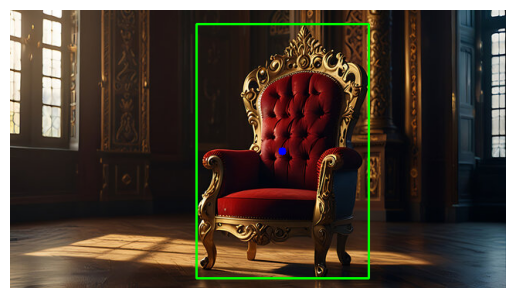

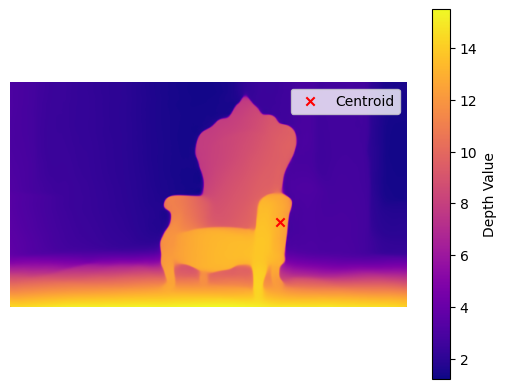

Depth at centroid (352, 183): 12.89 meters
Estimated Distance to Chair: 12.89 meters


In [5]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import supervision as sv
from transformers import AutoProcessor, AutoModelForDepthEstimation
from PIL import Image

# Load YOLOv8 model for object detection
model = YOLO("yolov8x.pt")  # Using YOLOv8x for high accuracy

# Load the image
image_path = "kingChair.jpg"  # Change to your image path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform object detection
results = model(image)

# Initialize centroid coordinates
centroid_x, centroid_y = None, None

# Extract bounding box of chair
for result in results:
    for box in result.boxes:
        cls = int(box.cls[0])  # Class ID
        if model.names[cls] == "chair":  # Check if detected object is a chair
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get bounding box coordinates
            centroid_x = (x1 + x2) // 2
            centroid_y = (y1 + y2) // 2
            print(f"Chair detected at: ({x1}, {y1}), ({x2}, {y2})")
            print(f"Centroid: ({centroid_x}, {centroid_y})")

            # Draw bounding box and centroid
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.circle(image, (centroid_x, centroid_y), 5, (0, 0, 255), -1)

# Save and display detected image
detected_image_path = "detected_chair.jpg"
cv2.imwrite(detected_image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

# Show detected image
plt.imshow(image)
plt.axis("off")
plt.show()

# Check if centroid was found
if centroid_x is None or centroid_y is None:
    print("No chair detected!")
else:
    # Load Depth Anything V2 model
    processor = AutoProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
    depth_model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

    # Convert image to PIL format
    image_pil = Image.open(image_path).convert("RGB")

    # Get depth map
    inputs = processor(image_pil, return_tensors="pt")
    with torch.no_grad():
        depth_output = depth_model(**inputs).predicted_depth

    # Convert depth map to NumPy array
    depth_map = depth_output.squeeze().cpu().numpy()

    # Show depth map
    plt.imshow(depth_map, cmap="plasma")
    plt.colorbar(label="Depth Value")
    plt.scatter(centroid_x, centroid_y, color="red", marker="x", label="Centroid")
    plt.legend()
    plt.axis("off")
    plt.show()

    # Query depth value at centroid
    depth_value = depth_map[centroid_y, centroid_x]
    print(f"Depth at centroid ({centroid_x}, {centroid_y}): {depth_value:.2f} meters")
    print(f"Estimated Distance to Chair: {depth_value:.2f} meters")


3.3.1  Draw bounding boxes around the "cars" using supervision. 

In [6]:
!pip install gdown

Defaulting to user installation because normal site-packages is not writeable


In [11]:
# Downloads the video file from the google drive link, you'll have to "pip install gdown" first
import gdown

file_id = "1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4"
direct_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(direct_url, "vehicles_video.mp4", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4
To: c:\Users\Hansani Bandara\Desktop\Assignment_02\vehicles_video.mp4
100%|██████████| 35.3M/35.3M [00:10<00:00, 3.53MB/s]


'vehicles_video.mp4'

In [7]:
import numpy as np
import supervision as sv
from ultralytics import YOLO

# Load YOLO model
model = YOLO("yolo11n.pt")  # Ensure the model file is present

# Define a BoxAnnotator instance (for drawing bounding boxes)
box_annotator = sv.BoxAnnotator()

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Run YOLO on the frame
    results = model(frame)

    # Convert results to Supervision format
    detections = sv.Detections.from_ultralytics(results[0])

    # Filter detections to keep only cars (assuming class ID for 'car' is 2)
    car_detections = detections[detections.class_id == 2]

    # Annotate frame using the BoxAnnotator
    annotated_frame = box_annotator.annotate(scene=frame, detections=car_detections)

    return annotated_frame

# Process the video
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="3.3.1._answer_result_tracking.mp4",
    callback=callback
)

print("Processing complete. Check '3.3.1._answer_result_tracking.mp4'")



0: 384x640 3 cars, 1 truck, 1163.4ms
Speed: 333.7ms preprocess, 1163.4ms inference, 34.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 1399.1ms
Speed: 470.8ms preprocess, 1399.1ms inference, 108.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 296.1ms
Speed: 6.6ms preprocess, 296.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 304.5ms
Speed: 17.1ms preprocess, 304.5ms inference, 12.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 610.7ms
Speed: 15.7ms preprocess, 610.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 550.4ms
Speed: 84.9ms preprocess, 550.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 240.3ms
Speed: 4.1ms preprocess, 240.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 362.6ms
Spe

3.3.1 Track the cars. Add the tracker id to the bounding boxes around the cars. Use supervision

In [11]:
import numpy as np
import supervision as sv
from ultralytics import YOLO

# Initialize YOLO model and tracker
model = YOLO("yolov8n.pt")  # Ensure this model exists
tracker = sv.ByteTrack()

# Initialize annotators
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

def detect_objects(frame: np.ndarray) -> sv.Detections:
    """Runs YOLO model to detect objects and converts results to Supervision format."""
    results = model(frame)
    return sv.Detections.from_ultralytics(results[0])

def track_objects(detections: sv.Detections) -> sv.Detections:
    """Tracks detected objects using ByteTrack."""
    return tracker.update_with_detections(detections)

def annotate_frame(frame: np.ndarray, detections: sv.Detections) -> np.ndarray:
    """Draws bounding boxes and labels with tracker IDs."""
    labels = [f"ID {round(track_id)}" for track_id in detections.tracker_id]
    frame = box_annotator.annotate(scene=frame, detections=detections)
    frame = label_annotator.annotate(scene=frame, detections=detections, labels=labels)
    return frame

def process_frame(frame: np.ndarray, _: int) -> np.ndarray:
    """Processes each video frame: detection, tracking, and annotation."""
    detections = detect_objects(frame)
    tracked_detections = track_objects(detections)
    return annotate_frame(frame, tracked_detections)

def process_video(source: str, target: str):
    """Processes a video using the detection and tracking pipeline."""
    sv.process_video(source_path=source, target_path=target, callback=process_frame)
    print(f"Processing complete! Check '{target}'")

# Run video processing
process_video("vehicles_video.mp4", "tracked_cars.mp4")



0: 384x640 3 cars, 1 truck, 447.0ms
Speed: 7.2ms preprocess, 447.0ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 470.3ms
Speed: 9.6ms preprocess, 470.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 1 truck, 385.8ms
Speed: 5.5ms preprocess, 385.8ms inference, 7.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 1 truck, 243.2ms
Speed: 6.3ms preprocess, 243.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 231.3ms
Speed: 5.3ms preprocess, 231.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 bus, 1 truck, 215.6ms
Speed: 4.5ms preprocess, 215.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 207.7ms
Speed: 4.3ms preprocess, 207.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 212.9

3.3.2 Draw the track traces for the tracked cars. Use supervision

In [12]:
import numpy as np
import supervision as sv
from ultralytics import YOLO

# Initialize YOLO model and tracker
model = YOLO("yolov8n.pt")  # Ensure this model exists
tracker = sv.ByteTrack()

# Initialize annotators
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()  # NEW: For drawing track traces

def detect_objects(frame: np.ndarray) -> sv.Detections:
    """Runs YOLO model to detect objects and converts results to Supervision format."""
    results = model(frame)
    return sv.Detections.from_ultralytics(results[0])

def track_objects(detections: sv.Detections) -> sv.Detections:
    """Tracks detected objects using ByteTrack."""
    return tracker.update_with_detections(detections)

def annotate_frame(frame: np.ndarray, detections: sv.Detections) -> np.ndarray:
    """Draws bounding boxes, labels, and track traces."""
    labels = [f"ID {round(track_id)}" for track_id in detections.tracker_id]
    
    # Draw track traces
    frame = trace_annotator.annotate(scene=frame, detections=detections)
    
    # Draw bounding boxes
    frame = box_annotator.annotate(scene=frame, detections=detections)
    
    # Draw tracker ID labels
    frame = label_annotator.annotate(scene=frame, detections=detections, labels=labels)
    
    return frame

def process_frame(frame: np.ndarray, _: int) -> np.ndarray:
    """Processes each video frame: detection, tracking, and annotation."""
    detections = detect_objects(frame)
    tracked_detections = track_objects(detections)
    return annotate_frame(frame, tracked_detections)

def process_video(source: str, target: str):
    """Processes a video using the detection and tracking pipeline."""
    sv.process_video(source_path=source, target_path=target, callback=process_frame)
    print(f"Processing complete! Check '{target}'")

# Run video processing
process_video("vehicles_video.mp4", "3.3.2._tracked_cars_with_traces.mp4")



0: 384x640 3 cars, 1 truck, 588.3ms
Speed: 9.0ms preprocess, 588.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 256.0ms
Speed: 7.0ms preprocess, 256.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 1 truck, 234.3ms
Speed: 4.6ms preprocess, 234.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 1 truck, 218.1ms
Speed: 7.2ms preprocess, 218.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 345.1ms
Speed: 4.9ms preprocess, 345.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 bus, 1 truck, 315.2ms
Speed: 8.0ms preprocess, 315.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 251.9ms
Speed: 3.7ms preprocess, 251.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 286.3

Questions:

Explain what "def callback(frame: np.ndarray, _: int) -> np.ndarray:" does. 

Function Definition  
The `callback` function processes an image or video frame and returns a modified version. It uses Python's type hinting to indicate that both input and output are `np.ndarray`, making it suitable for image processing tasks.  

Parameters  
   `frame: np.ndarray` – Represents a single image or frame from a video sequence stored as a NumPy array. This allows for efficient mathematical operations and image transformations.  
   `_: int` – A placeholder integer argument (e.g., frame index or timestamp). The underscore (`_`) convention signals that this parameter is provided by the caller but not used in the function.  

Return Type (`np.ndarray`) 
The function returns a NumPy array, meaning it likely processes the input frame and applies transformations such as grayscale conversion, edge detection, or object detection before returning the modified frame.  

Use Cases and Applications
This function is useful in real-time video processing pipelines, such as:  
-Object Detection & Tracking – Modifying frames before passing them to a machine learning model.  
-Augmented Reality (AR) – Processing video frames for real-time overlay of digital elements.  
-Surveillance & Monitoring – Enhancing video streams with filtering or detection techniques.  



Answers: Complete this section